<a href="https://colab.research.google.com/github/Cosmox999/SOC-RL/blob/main/Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, Reward: 0.0, Epsilon: 1.00
Episode: 1000, Reward: 1.0, Epsilon: 0.37
Episode: 2000, Reward: 0.0, Epsilon: 0.14
Episode: 3000, Reward: 1.0, Epsilon: 0.05
Episode: 4000, Reward: 1.0, Epsilon: 0.02
Episode: 5000, Reward: 1.0, Epsilon: 0.01
Episode: 6000, Reward: 1.0, Epsilon: 0.01
Episode: 7000, Reward: 1.0, Epsilon: 0.01
Episode: 8000, Reward: 1.0, Epsilon: 0.01
Episode: 9000, Reward: 1.0, Epsilon: 0.01


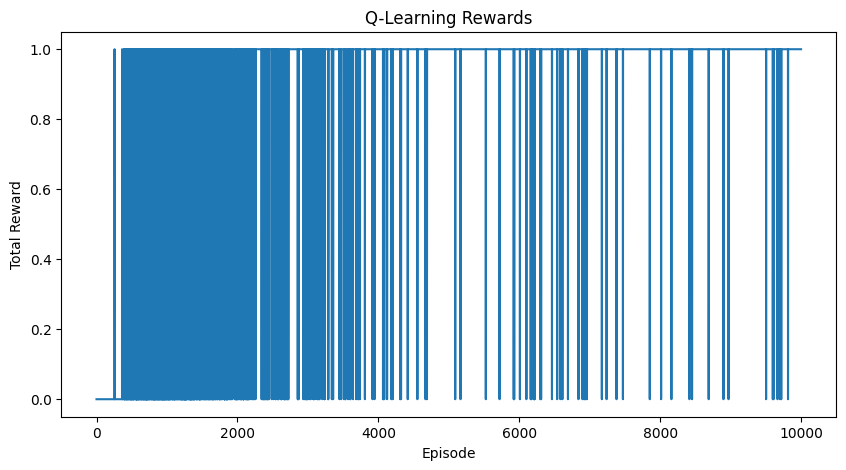

/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
from IPython.display import HTML
from base64 import b64encode
import os

def train_q_learning(env, episodes=10000, alpha=0.1, gamma=0.99, epsilon=1.0, min_epsilon=0.01, decay=0.999):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # Handle newer Gym versions
            state = state[0]
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            result = env.step(action)
            if len(result) == 4:  # Handle older Gym versions
                next_state, reward, done, _ = result
            else:  # Handle newer Gym versions
                next_state, reward, terminated, truncated, _ = result
                done = terminated or truncated

            # Q-learning update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state
            total_reward += reward

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * decay)
        rewards.append(total_reward)

        if episode % 1000 == 0:
            print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return Q, rewards

def plot_rewards(rewards, title="Q-Learning Rewards"):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.savefig("q_learning_rewards.png")
    plt.show()

def show_video(video_path):
    # List all MP4 files in the video directory
    video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]

    if not video_files:
        print("No video files found")
        return

    # Show the first video found
    video_file = os.path.join(video_path, video_files[0])

    # Display the video in Colab
    mp4 = open(video_file, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""
    <video width=400 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))

if __name__ == "__main__":
    # Create environment
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='rgb_array')

    # Train the agent
    Q, rewards = train_q_learning(env)
    plot_rewards(rewards)

    # Save Q-table
    np.save("q_table.npy", Q)

    # Close the training environment
    env.close()

    # Create new environment for recording
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='rgb_array')

    # Create a directory for videos
    video_dir = "/content/videos"
    os.makedirs(video_dir, exist_ok=True)

    # Wrap the environment with RecordVideo
    env = RecordVideo(env, video_dir, name_prefix="q_learning", episode_trigger=lambda x: True)

    # Run one episode for recording
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False

    while not done:
        action = np.argmax(Q[state])
        result = env.step(action)
        if len(result) == 4:
            next_state, _, done, _ = result
        else:
            next_state, _, terminated, truncated, _ = result
            done = terminated or truncated
        state = next_state

    env.close()

    # Show the recorded video
    show_video(video_dir)